# Unstable fits: why fits fail and how to fix it

In practice, it is quite common that a fit does not work as intended in the beginning. The fit may fail to converge outright, or it works on some datasets but not on others. Debugging these issues requires experience and insight.

The most common reasons for unstable or failing fits are:
- Parameters which need bounds, for example, because they cannot be negative, do not have limits set and the fit enters the forbidden parameter region during minimization. This often causes the cost function to return infinity or NaN, which causes the fit to fail.
- The model has parameters which are not constrained by data. The gradient with respect to this parameter is approximately zero.
- The model is ambiguous: it has too many parameters and some parameters are perfectly (anti)correlated to others. This is a variation of the above problem.
- The model is not smooth: the gradient is discontinuous or noisy.

These issues cannot be solved by Minuit or any other fitting program, they need to be solved by the user. Ideally, Minuit would diagnose and report the exact issue to the user, but neither Minuit nor other fitting programs are very good at this.

Minuit still tries to handle pathological cases as good as possible, and Minuit is actually better at this than other minimizers. You can influence how hard Minuit tries to recover a pathological fit with the `Minuit.strategy` setting. The default is 1, but increasing this to 2 may make the fit converge at the cost of an increase in function evaluations. In fact, in `iminuit` we are doing this automatically, if the initial fit fails to converge. If you don't know good starting values, it can help to run `Minuit.simplex` first, before running `Minuit.migrad`. For failing fits, there we alternate between `Minuit.simplex` and `Minuit.migrad` by default, which seems to help. You can turn off iteration and the use of `Minuit.simplex` with keyword options.

Below we demonstrate the impact of these settings on a scenario with multiple pathologies. We do a least-squares fit of a line to data. Here are the pathologies:

1) The line has an additive parameter which is multiplied by a small factor. If this factor is not small, the data constrain the parameter and the fit will converge fine. If the factor is zero, the data won't be able to constrain the parameter at all, which causes an ambiguity in the model: whatever the value of the parameter, there is no change in the least-squares function. This causes the fit to fail because the gradient along this parameter is zero. In reality, we are often inbetween these extremes. The smaller the factor is, the close the gradient becomes to zero. We do the fit many times, scanning over the factor from 1e-10 to 1.

2) The line has a small random offset of 1e-6 added to it, so the gradient is slightly random. Minuit assumes that the gradient is exact to machine precision, so this will destabilize the fit.

We see how `Minuit.migrad` does on this, and for comparison, also run a few Scipy minimizers on the same problem.

In [1]:
import numpy as np
from iminuit.cost import LeastSquares
from iminuit import Minuit
from matplotlib import pyplot as plt
from dataclasses import dataclass

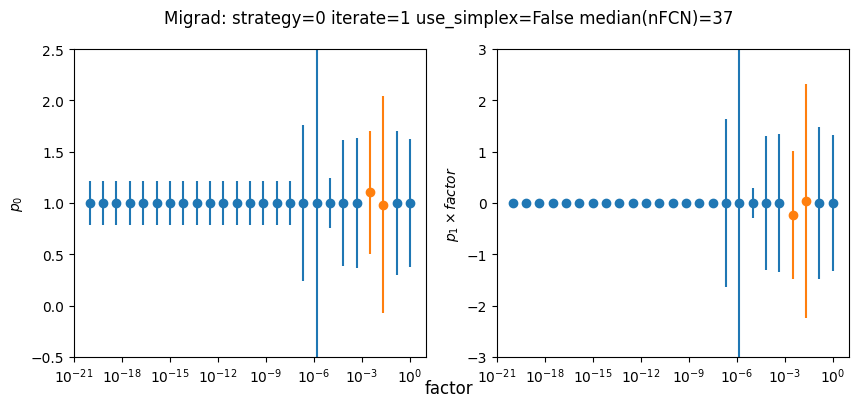

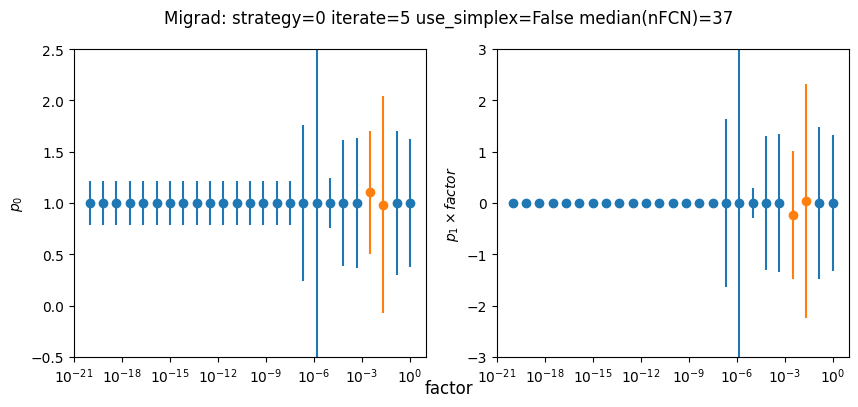

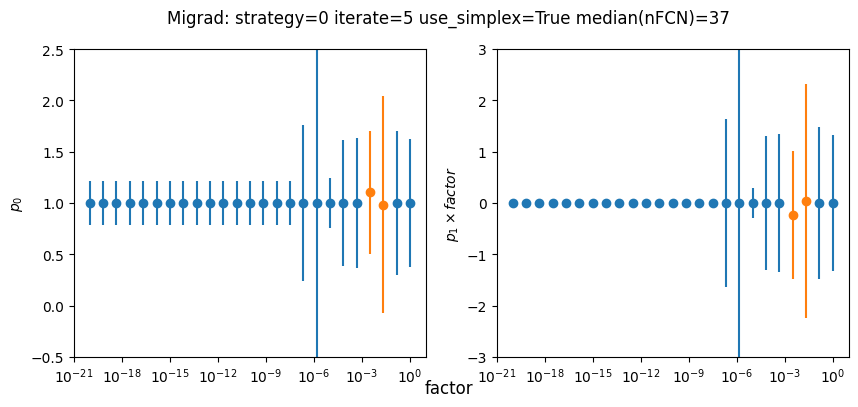

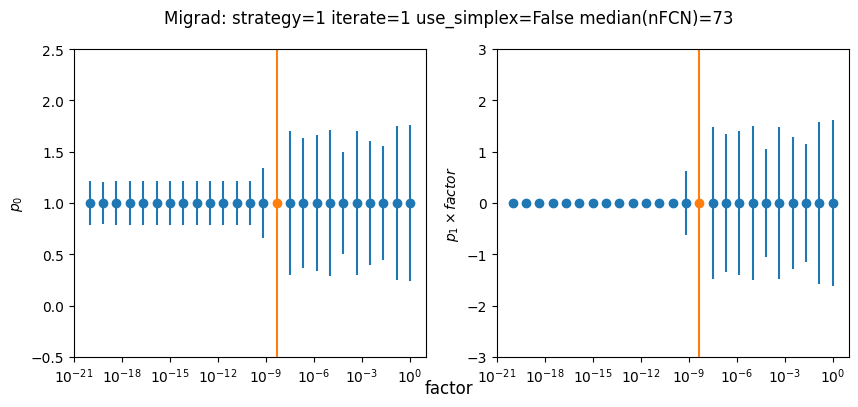

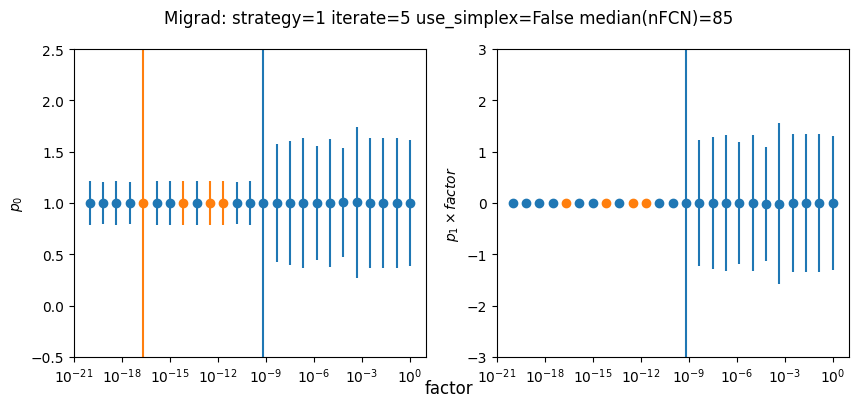

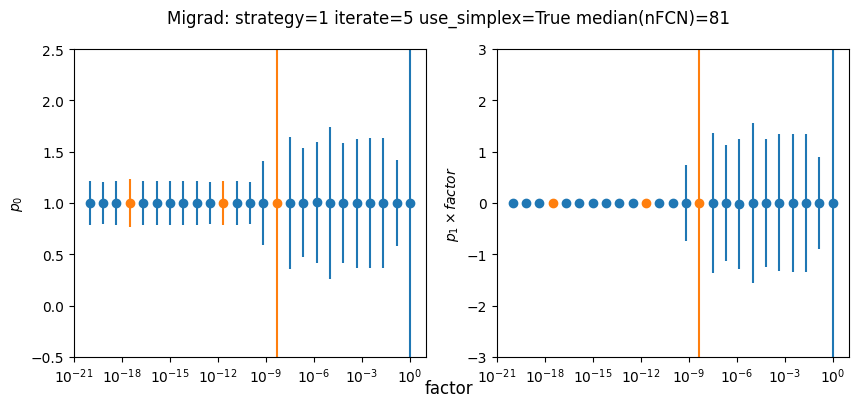

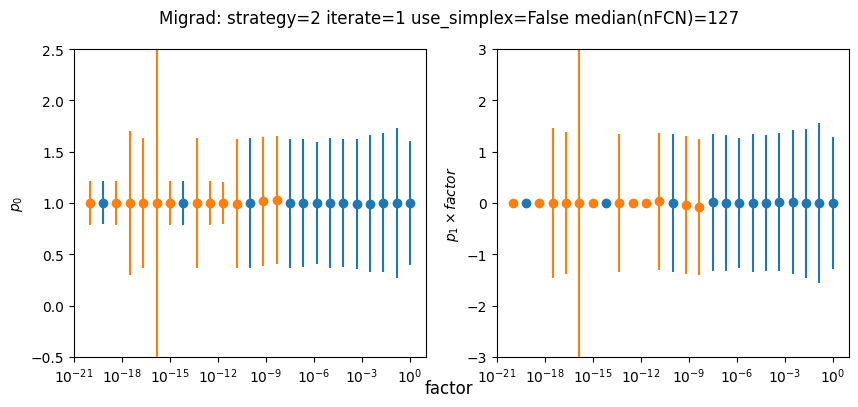

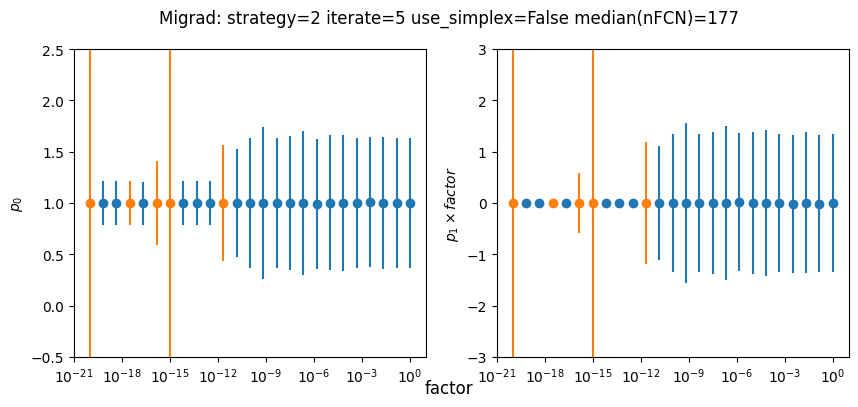

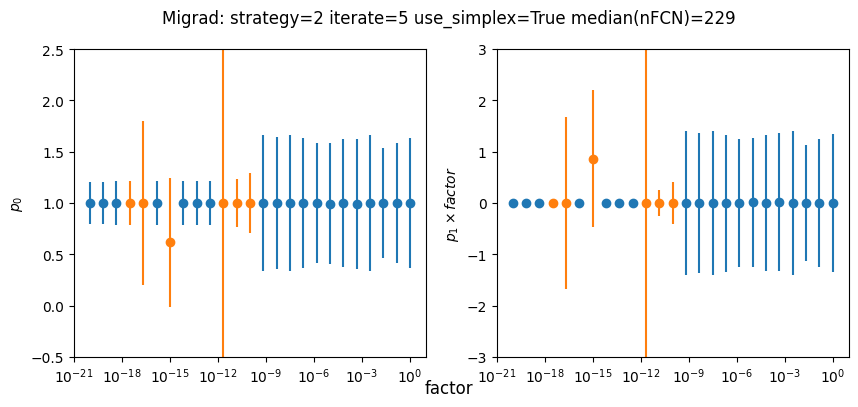

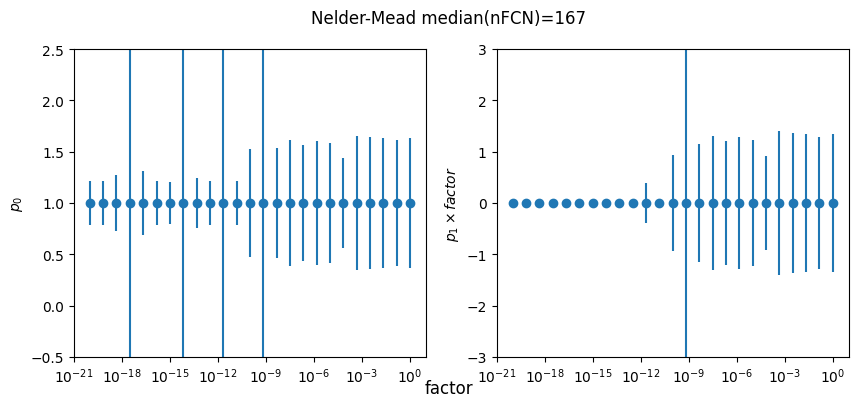

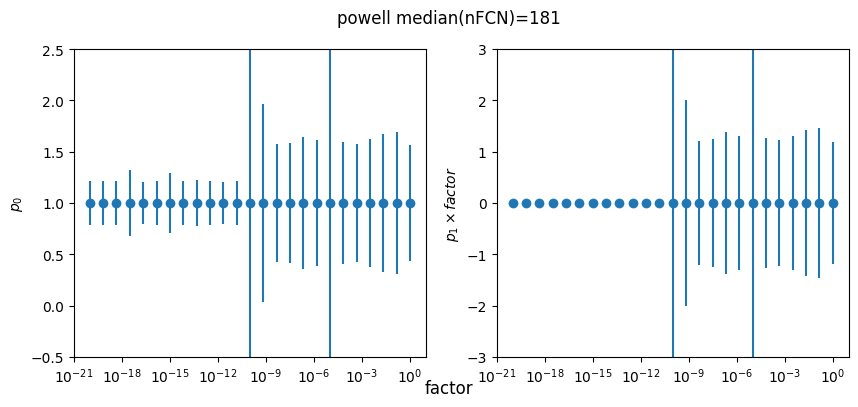

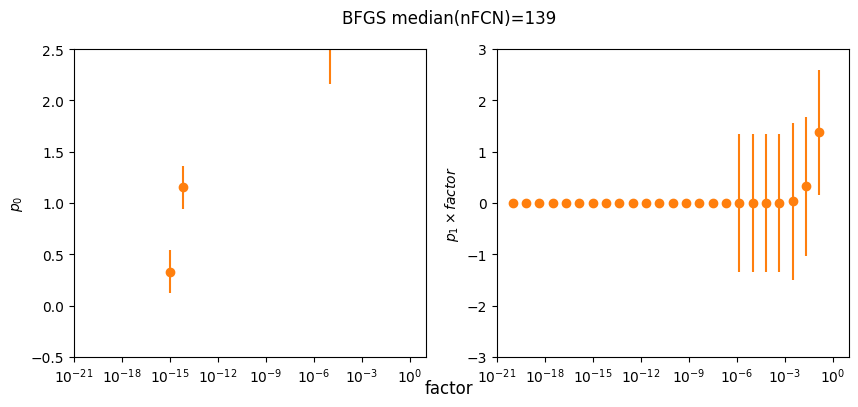

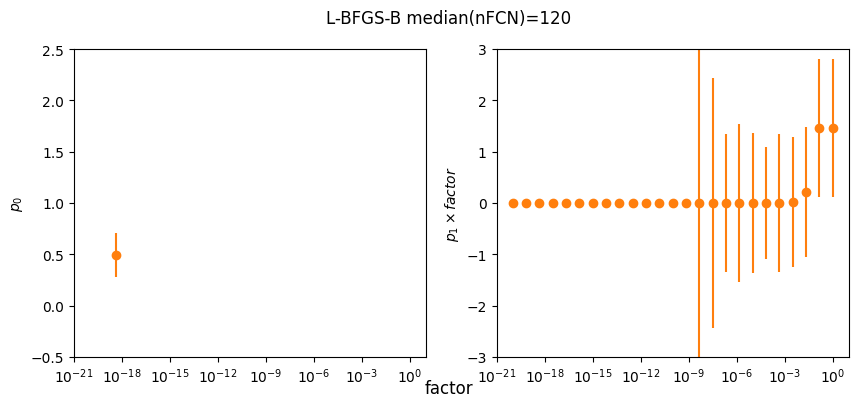

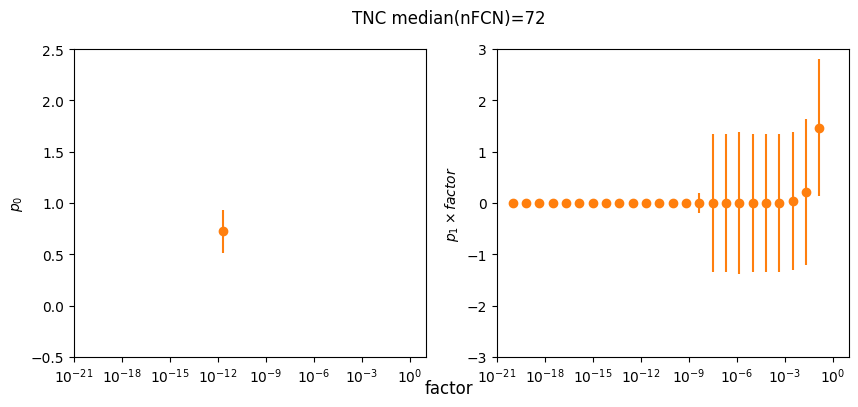

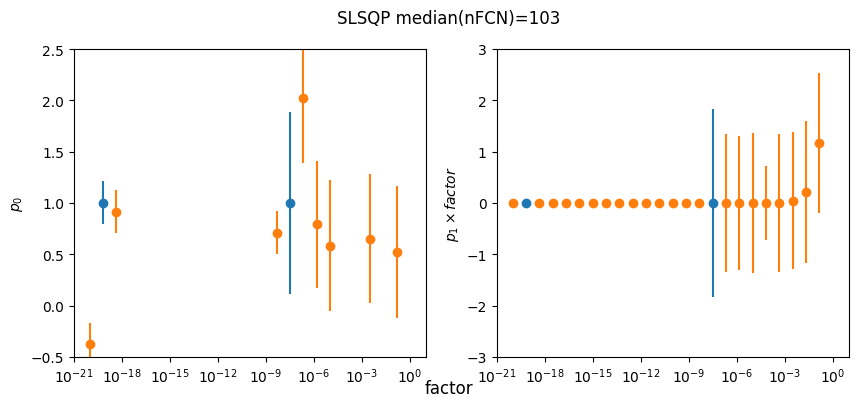

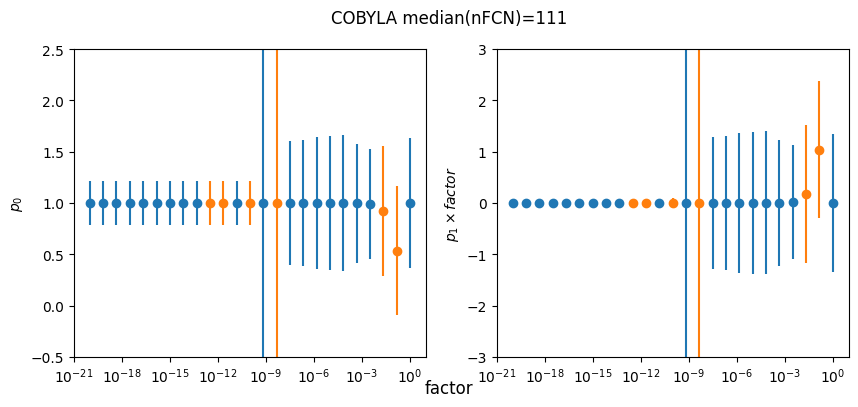

In [5]:
@dataclass
class Migrad:
    strategy: int
    iterate : int
    use_simplex: bool

    def __repr__(self):
        return f"Migrad: strategy={self.strategy} iterate={self.iterate} use_simplex={self.use_simplex}"



for minimizer in (
    Migrad(0, 1, False),
    Migrad(0, 5, False),
    Migrad(0, 5, True),
    Migrad(1, 1, False),
    Migrad(1, 5, False),
    Migrad(1, 5, True),
    Migrad(2, 1, False),
    Migrad(2, 5, False),
    Migrad(2, 5, True),
    "Nelder-Mead",
    "powell",
    "BFGS",
    "L-BFGS-B",
    "TNC",
    "SLSQP",
    "COBYLA"
):
    valid = []
    val = []
    err = []
    nfcn = []
    power = np.geomspace(1e-20, 1, 25)

    rng = np.random.default_rng(1)
    for p in power:

        def fn(x, par):
            return x * par[0] + 1 + p * par[1] + rng.normal(0.0, 1e-7)

        x = np.linspace(1, 3, 5)
        c = LeastSquares(x, fn(x, [1, 0]), 1, fn)
        m = Minuit(c, [10, 10])
        if isinstance(minimizer, Migrad):
            m.strategy = minimizer.strategy
            m.migrad(iterate=minimizer.iterate, use_simplex=minimizer.use_simplex)
        else:
            m.scipy(method=minimizer)
        m.hesse()
        valid.append(m.valid)
        val.append(m.values[:])
        err.append(m.errors[:])
        nfcn.append(m.nfcn)

    valid = np.array(valid)
    val = np.array(val)
    err = np.array(err)
    nfcn = np.array(nfcn)

    fig, ax = plt.subplots(1, 2, figsize=(10, 4), sharex=True)
    plt.suptitle(f"{minimizer} median(nFCN)={np.mean(nfcn):.0f}")
    for v in (True, False):
        m = valid == v
        plt.sca(ax[0])
        plt.errorbar(power[m], val[m, 0], err[m, 0], fmt="o")
        plt.sca(ax[1])
        plt.errorbar(power[m], val[m, 1] * power[m], err[m, 1] * power[m], fmt="o")
    plt.sca(ax[0])
    plt.semilogx()
    plt.ylabel(r"$p_0$")
    plt.ylim(-0.5, 2.5)
    plt.sca(ax[1])
    plt.semilogx()
    plt.ylabel(r"$p_1 \times factor$")
    plt.ylim(-3, 3)
    fig.supxlabel("factor")

`Minuit.migrad` handles pathological cases quite well compared to many Scipy minimizers. Scipy minimizers which don't compute a gradient (Nelder-Mead, Powell, COBYLA) also do well on our noisy model, as can be expected. Nevertheless, the performance of `Minuit.migrad` with strategy 1 is better, it reaches the minimum faster than the other minimizers while being similarly robust.

The interleaving of `Minuit.migrad` and `Minuit.simplex` calls is a mixed bag in this toy scenario. The default is to use `Minuit.simplex` however, because `Minuit.simplex` can often reach the minimum from poorly chosen starting values, a pathological case which we are not testing here.